## 1. Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
#!pip install mlxtend

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/pictures.zip", "r") as zip:
    zip.extractall()

## 2. Data Pre-processing

In [ ]:
# path to read files
path = 'KDEF (reeks A) zonder haarlijn'

filenames = os.listdir(path) # retrieve filenames
filenames.remove('Thumbs.db') # remove file that doesnt contain image
print("Total files present in the filenames set is {}.".format(len(filenames)))

In [ ]:
# getting labels out of the data
label = list()
# there are 7 labels present in the dataset
for i in filenames:
    if "SA" in i:
        label.append("SA")
    elif "SU" in i:
        label.append("SU")
    elif "AN" in i:
        label.append("AN")
    elif "DI" in i:
        label.append("DI")
    elif "NE" in i:
        label.append("NE")
    elif "AF" in i:
        label.append("AF")
    elif "HA" in i:
        label.append("HA")
    else:
        print(i)
# AF - fear, HA - happy, DI - disgust, AN- anger, SU - surprise, SA - sad

In [ ]:
# creating a dataframe using filenames and labels
df = pd.DataFrame()
df["filenames"] = filenames
df["labels"] = label
df = df.sort_values(by="filenames")
df["person"] = df["filenames"].apply(lambda x:x[0:1])

In [ ]:
df["person"].value_counts()

In [ ]:
# checking the class distribution
plot = df["labels"].value_counts().plot(kind = "bar", title="Data Distribtion")
plt.show()

## 3. Checking shape and size of the data



In [ ]:
# getting filepath
file_path = path + "/" + str(df["filenames"].values[40])
                                        
img_gray = cv2.imread(file_path, cv2.IMREAD_COLOR) #method loads an image from the specified file
#$cv2_imshow(img_gray) #display image

In [ ]:
# the pixel values are
print("Shape of the image is {}.".format(img_gray.shape))

## 4. Labeling and Splitting of data

In [ ]:
df["encoded_label"] = df["labels"].map({"AN":0, "DI":1, "AF":2, "HA":3, "NE":4, "SA":5, "SU":6})
df.sample(2)

In [ ]:
y = df["encoded_label"]
z = df[["encoded_label", "person"]]
X = df

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, stratify=z, random_state=34)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

In [ ]:
train_df = xtrain
train_df["encoded_label"] = ytrain

test_df = xtest.sort_index()
test_df["encoded_label"] = ytest

train_df = train_df.sort_index().reset_index()
test_df = test_df.sort_index().reset_index()

train_df.shape, test_df.shape

## 5. Import Torch dependencies

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import torch
import torch.nn as nn
from PIL import Image
from torch import optim

from torch.optim import Adam, SGD
from torch.autograd import Variable
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential
from torch.nn import Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

## 6. Creating Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            df  (string):                    Dataframe
            root_dir   (string):             Path where all images are present.
            id_col     (string):             Input column name where all image name is present in the dataframe
            target_col (string):             Target Label Column name present in the dataframe
            sufix      (string, optional):   Optional sufix for samples if needed.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = df
        self.id = id_col 
        self.target = target_col
        self.root = root_dir
        self.sufix = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # getting image name
        img_name = self.data.loc[idx, self.id]
        # if suffix is present then add in the image name
        if self.sufix is not None:
            img_name = img_name + self.sufix
        # opening image using PIL
        image = Image.open(os.path.join(self.root, img_name))

        if self.transform is not None:
            image = self.transform(image)
        
        image = np.asarray(image)
        #image = cv2.imread(os.path.join(self.root, img_name), cv2.IMREAD_COLOR)
        
        # reshaping the image into required shape
        image = image.reshape(3, 224, 224)
        
        label = self.data.loc[idx, self.target]
        labels = np.array(label)

        return image, labels

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ])
}

# setting up parameters
params_train = {'id_col' : 'filenames', 'target_col': 'encoded_label', 'transform': data_transforms["train"]}
params_test = {'id_col' : 'filenames', 'target_col': 'encoded_label', 'transform': data_transforms["test"]}

In [ ]:
##creating custom train and test dataset
train_dataset = CustomDataset(df = train_df, root_dir = path, **params_train)
test_dataset = CustomDataset(df = test_df, root_dir = path, **params_test)

## 7. Pushing Data into Train Loader


In [ ]:
# creating train loader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=4)
# creating test loader
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False,  num_workers=4)

## 8. Building Model pre-trained resnet50

In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Sequential(nn.Linear(2048, 1028),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(1028, 7),
                                 nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## 9. Training the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 15
steps = 0
running_loss = 0

print_every = len(train_loader)
train_losses = list()
test_losses = list()
train_acc = list()
test_acc = list()

for epoch in range(epochs):
    train_accuracy = 0
    # train loader loss calculation and getting test accuracy
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs.float())
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # accuracy 
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # for test data
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs.float())
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # appeding loss and accuracy values
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            train_acc.append(train_accuracy/len(train_loader))
            test_acc.append(accuracy/len(test_loader))

            # printing values                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Train accuracy: {train_accuracy/print_every:.3f}.."
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            # train model
            model.train()

## 10. Prediction

In [44]:
actual_ = list()
predicted_ = list()
total_class = 7

# Estimate class-wise accuracy
class_correct = list(0. for i in range(total_class))
class_total = list(0. for i in range(total_class))

with torch.no_grad():
    # getting prediction
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        outputs = model(images.float())

        # getting prediction
        _, predicted = torch.max(outputs, 1)
        
        # appending prediction
        predicted_.append(list(predicted.cpu().numpy()))
        actual_.append(list(labels.cpu().numpy()))

In [45]:
# getting prediction value
ypred = [i for idx in range(len(predicted_)) for i in predicted_[idx]]
ytest = [i for idx in range(len(actual_)) for i in actual_[idx]]

## 11. Plots

In [46]:
def plots(train_loss, test_loss, train_accuracy, test_accuracy, col, size):
    """
    This function provides the accuracy and loss plot for the model.
    """    
    fig, axes = plt.subplots(ncols = col, figsize=size)
    # loss plot
    axes[0].plot(train_loss, color="r");  axes[0].plot(test_loss,  color="g")
    #setting up ticks
    axes[0].set_xticks(range(0,len(train_loss)))
    axes[0].legend(["Train_Loss", "Validation_Loss"])
    #setting up labels
    axes[0].set_xlabel("Number of Epochs", fontsize=15)
    axes[0].set_ylabel("Log Loss", fontsize=15)
    axes[0].set_title("Loss plot for train and validation dataset", fontsize=15)
    # accuracy plot
    axes[1].plot(train_accuracy, color="r");  axes[1].plot(test_accuracy, color="g")
    #setting up ticks
    axes[1].set_xticks(range(0,len(train_loss)))
    axes[1].legend(["Train_Accuracy", "Validation_Accuracy"])
    #setting up labels
    axes[1].set_xlabel("Number of Epochs", fontsize=15)
    axes[1].set_ylabel("Accuracy", fontsize=15)
    axes[1].set_title("Accuracy Plot for train and validation dataset", fontsize=15)
    
    return plt.show()

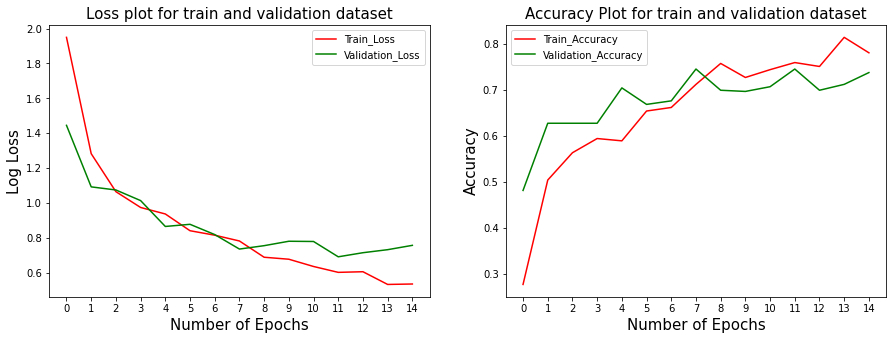

In [47]:
plots(train_losses, test_losses, train_acc, test_acc, 2, (15,5))

## 11. Scores and confusion matrix

In [48]:
from sklearn import metrics
# accuracy scores
print("Accuracy Score        {:.4f}.".format(metrics.accuracy_score(ytest,ypred)))
print("Overall f1 score      {:.4f}.".format(metrics.f1_score(ytest, ypred, average='micro')))
print("Overall Precision     {:.4f}.".format(metrics.precision_score(ytest, ypred, average='micro')))
print("Overall Recall        {:.4f}.".format(metrics.recall_score(ytest, ypred, average='micro')))
print("Classification Report :\n",metrics.classification_report(ytest,ypred))

Accuracy Score        0.6748.
Overall f1 score      0.6748.
Overall Precision     0.6748.
Overall Recall        0.6748.
Classification Report :
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        17
           1       0.63      0.94      0.76        18
           2       0.61      0.65      0.63        34
           3       1.00      0.83      0.91        18
           5       0.75      0.33      0.46        18
           6       0.68      0.72      0.70        18

    accuracy                           0.67       123
   macro avg       0.71      0.68      0.67       123
weighted avg       0.69      0.67      0.67       123



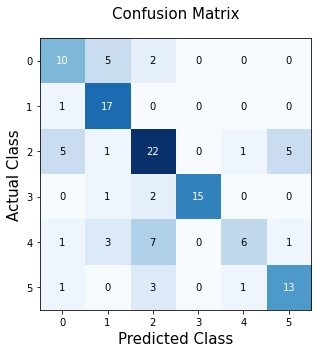

In [49]:
# confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(ytest,ypred), figsize=(5, 5))
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Actual Class", fontsize=15)
plt.title("Confusion Matrix", fontsize=15)
plt.show()